In [1]:
import importlib
import tempfile
import os
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from turbustat.statistics import pspec

from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils
import makefigures_noise

In [29]:
def scaled_imshow ( im, ax=None, beta=0.01, colorbar=True, interpolation=None ):
    if ax is None:
        ax = plt.subplot(111)
    vmin, vmax = np.nanquantile ( im, [beta, 1. - beta] )
    if interpolation is not None:
        imout = ax.imshow ( im, vmin=vmin, vmax=vmax, interpolation=interpolation )
    else:
        imout = ax.imshow ( im, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar ( imout, ax=ax )
    return ax

def recast (colmed, dt):
    recast = np.ones(dt.size, dtype=float)
    for idx,dindex in enumerate(np.unique(dt)):
        recast[dt==dindex] = colmed[idx]    
    return recast

In [3]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]
rampids = makefigures_noise.load_rampids ()

In [4]:
rampA = hxramp.HxRamp(io.jhu2tiger(bestbaselines[0]))
rampB = hxramp.HxRamp(io.jhu2tiger(bestbaselines[1]))

In [5]:
nbins = 5
step = rampA.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, rampA.ncols, step)[:-1], [rampA.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [6]:
i = 10
inext = 11

In [7]:
im0 = rampA.dataN(i)
im1 = rampA.dataN(inext)

In [8]:
irp0 = rampA.irpN(i)
irp1 = rampA.irpN(inext)

<AxesSubplot:>

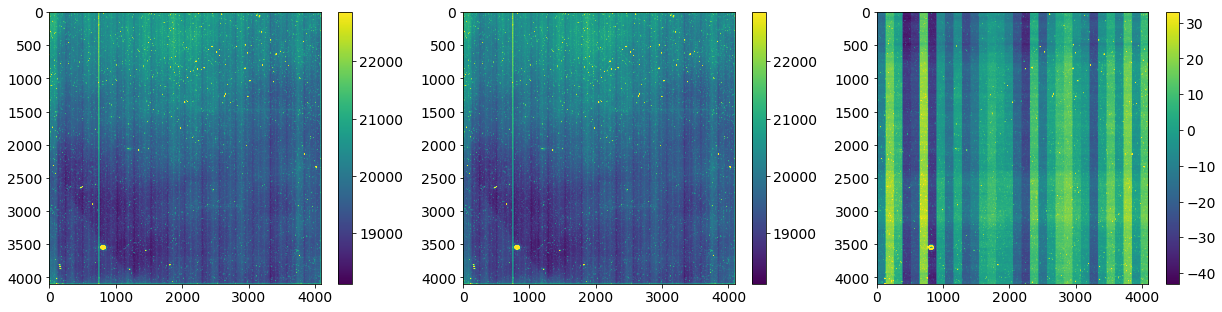

In [9]:
fig, axarr = plt.subplots(1,3, figsize=(21,5))
scaled_imshow(im0, ax=axarr[0])
scaled_imshow(im1, ax=axarr[1])
scaled_imshow(im1.astype(float)-im0.astype(float), ax=axarr[2])

<AxesSubplot:>

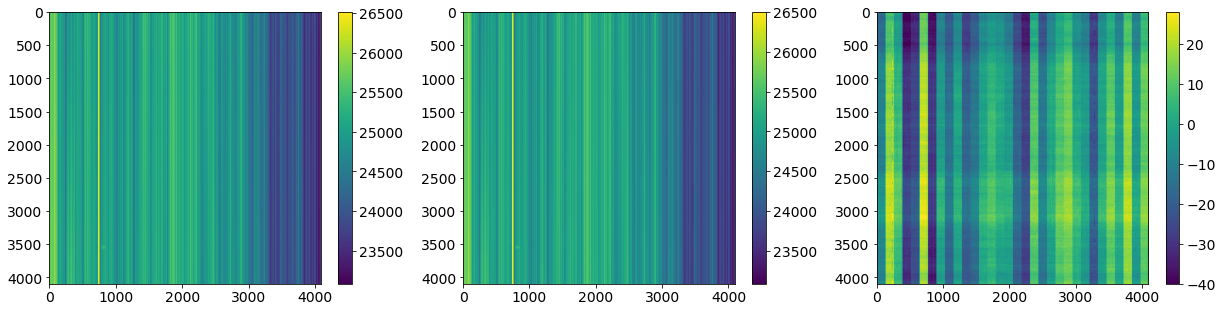

In [10]:
fig, axarr = plt.subplots(1,3, figsize=(21,5))
scaled_imshow(irp0, ax=axarr[0])
scaled_imshow(irp1, ax=axarr[1])
scaled_imshow(irp1.astype(float)-irp0.astype(float), ax=axarr[2] )

<AxesSubplot:>

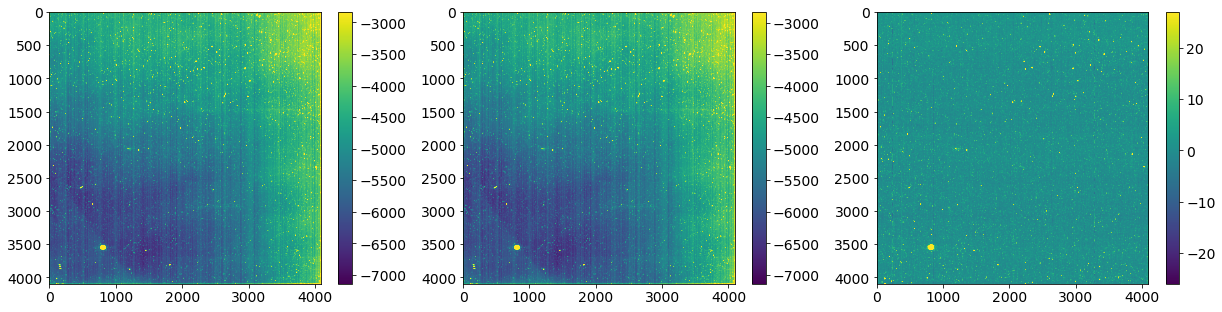

In [11]:
fig, axarr = plt.subplots(1,3, figsize=(21,5))

d0 = im0.astype(float)-irp0.astype(float)
d1 = im1.astype(float)-irp1.astype(float)
scaled_imshow(d0, ax=axarr[0])
scaled_imshow(d1, ax=axarr[1])
scaled_imshow(d1-d0, ax=axarr[2] )

In [22]:
irpdiff = irp1.astype(float)#-irp0.astype(float)

In [23]:
from scipy import ndimage

In [24]:
xs = np.arange(irpdiff.shape[1])
bins = np.arange(0,xs.max() + 2, 128)
midpts = 0.5*(bins[1:]+bins[:-1])
dt = np.digitize (xs, bins)


In [25]:
rowmed = np.median ( irpdiff, axis=0 )
colmed = ndimage.median ( rowmed, labels=dt, index=np.unique(dt) )

In [30]:
recrow = recast ( colmed, dt )

In [31]:
from scipy import stats

In [32]:
rowdiff = rowmed - recrow
sclip = stats.sigmaclip(rowdiff)
cpd_diff = irpdiff.copy ()
cpd_diff[:,(rowdiff>sclip.upper)|(rowdiff<sclip.lower)] = np.NaN
cpd_rowmed = np.nanmedian(cpd_diff, axis=0)
cpd_colmed = ndimage.median ( cpd_rowmed, labels=dt, index=np.unique(dt) )

In [33]:
clist = np.random.uniform(0.,1., [bins.size-1, 3])
cmap = colors.LinearSegmentedColormap.from_list ( 'random', clist, bins.size-1 )
recast_arr = recast ( cpd_colmed, dt)

In [35]:
normalized = np.ones(irpdiff.shape, dtype=float)*recast_arr

<AxesSubplot:xlabel='x', ylabel='y'>

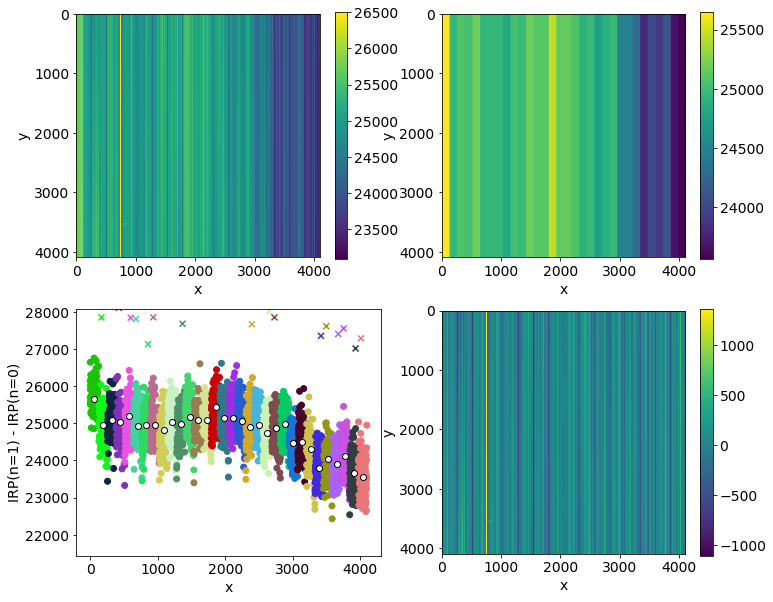

In [55]:
fig, axarr = plt.subplots(2,2, figsize=(12,10))

scaled_imshow(irpdiff, ax=axarr[0,0])
scaled_imshow(normalized, ax=axarr[0,1])

rmvd = np.isnan(cpd_rowmed)
axarr[1,0].scatter(xs[rmvd], rowmed[rmvd], marker='x', c=dt[rmvd], cmap=cmap, vmin=dt.min(), vmax=dt.max())
axarr[1,0].scatter(xs, cpd_rowmed, c=dt, cmap=cmap)
axarr[1,0].scatter ( midpts, colmed, ec='k', fc='w')
axarr[1,0].set_ylim( np.nanmean(cpd_rowmed)-5*np.nanstd(cpd_rowmed),  
                     np.nanmean(cpd_rowmed)+5*np.nanstd(cpd_rowmed))
for ax in axarr.flatten():
    ax.set_xlabel ( 'x' )
for ax in axarr[0]:
    ax.set_ylabel('y')
axarr[1,0].set_ylabel(r'IRP(n=1) - IRP(n=0)')
axarr[1,1].set_ylabel('y')
scaled_imshow(irpdiff-normalized, ax=axarr[1,1] )

In [56]:
irp_cmr = irpdiff-normalized

<AxesSubplot:>

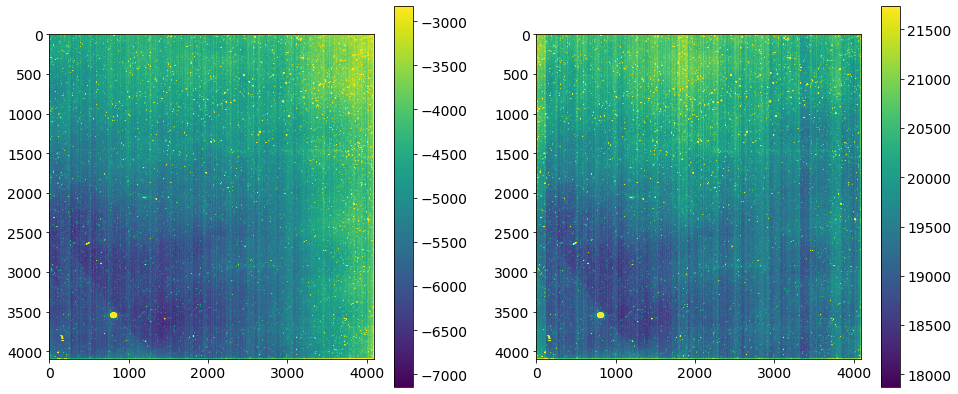

In [57]:
fig, axarr = plt.subplots(1,2,figsize=(16,7))
scaled_imshow ( im1.astype(float) - irp1.astype(float), ax=axarr[0]  )
scaled_imshow ( im1.astype(float) - irp_cmr, ax=axarr[1]  )

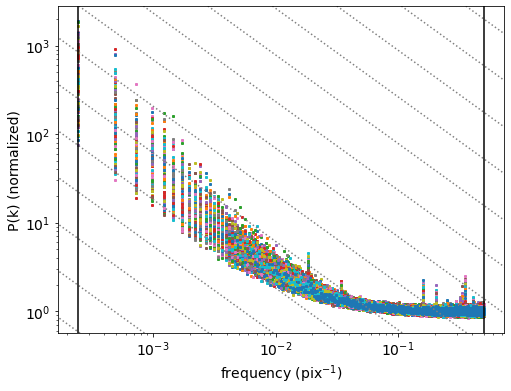

In [443]:
fig = plt.figure (figsize=(8,6))
ax = plt.subplot(111)

for jdx in range(idx):
    normalized = psflattened[jdx, abs(yfreqs)>0.2].mean()
    ax.scatter ( np.abs(yfreqs), psflattened[jdx]/normalized, s=2**2, zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x = np.logspace ( -4, 0., 30)
for aconst in np.logspace(-7,3,20):
    ax.plot ( x, 1./x *aconst, color='grey', ls=':' )
ax.axvline(1./4096., color='k')
ax.axvline(1./2., color='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel ( r'frequency (pix$^{-1}$)')
ax.set_ylabel ( r'P(k) (normalized)')
ax.set_rasterization_zorder ( 1 )

In [157]:
from astropy import units as u
from astropy.io import fits

In [23]:
fncd = irpdiff-normalized

In [227]:
header= fits.Header ()

In [228]:
pspec = PowerSpectrum ( fncd, header=header )

/tigress/kadofong/machine_harmony/repos_post0903/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


In [229]:
pspec.compute_pspec()

<AxesSubplot:>

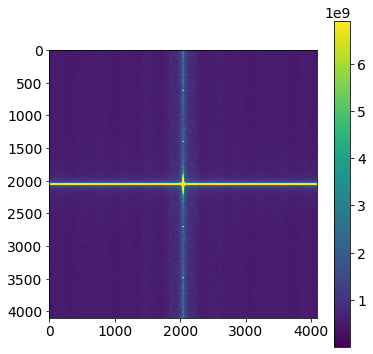

In [230]:
scaled_imshow(pspec._ps2D)

In [425]:
Y,X = np.mgrid[:800,:800]
Z = 10.*np.sin(X/100.) 
#Z = 10.*np.exp(-(X-X.mean())**2/(2.*40.**2))
Z *= 10.*np.exp(-(Y-Y.mean())**2/(2.*5.**2))
Z += np.random.normal(0.,10., X.shape)
psZ, xfreqs,yfreqs = ramputils.ps2D ( Z )

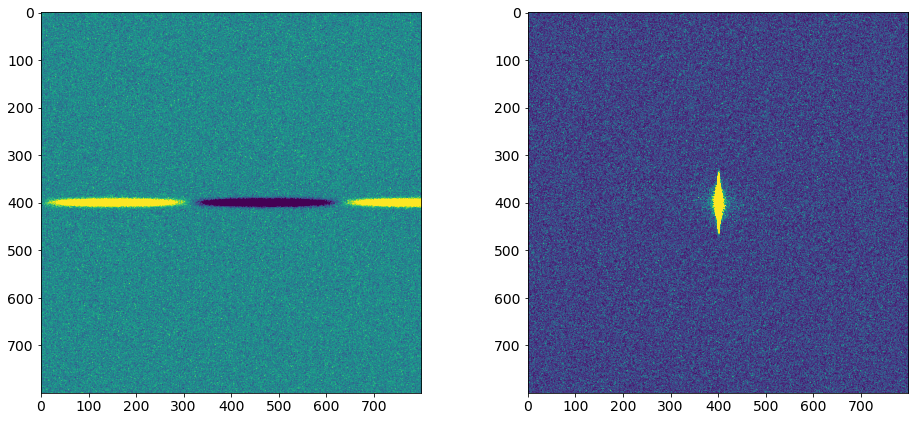

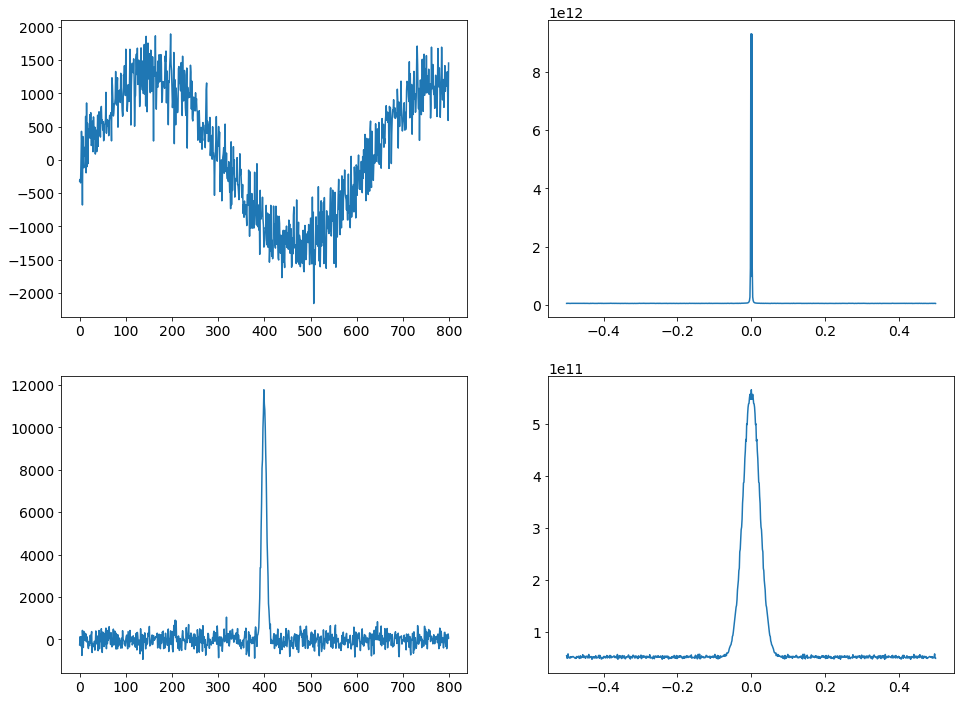

In [428]:
fig,axarr = plt.subplots(1,2, figsize=(16,7), )
scaled_imshow(Z, ax=axarr[0], colorbar=False)
scaled_imshow(psZ, ax=axarr[1],colorbar=False)

fig, axarr = plt.subplots(2,2, figsize=(16,12))
axarr[0,0].plot(np.sum(Z, axis=0))
axarr[0,1].plot(xfreqs, np.sum(psZ, axis=0 ))
axarr[1,0].plot(np.sum(Z, axis=1))
axarr[1,1].plot(yfreqs, np.sum(psZ, axis=1 ))

In [453]:
start = 78
irp0 = rampA.irpN ( start )
if start == 0:
    pcmed = np.zeros([300, 4096])
    prmed = np.zeros([300, 32])
    psflattened = np.zeros([300, 4096])
for idx in range(start, 300):
    irp1 = rampA.irpN(idx+1)
    fncd, cpd_colmed = ramputils.correct_IRPpcv ( irp1, irp0 )
    pcmed[idx] = np.median(fncd,axis=1)
    prmed[idx] = cpd_colmed
    
    # \\ compute power spectrum
    ps2D, xfreqs, yfreqs = ramputils.ps2D ( fncd )
    pscollapse = np.sum(ps2D, axis=1)
    #normalization = pscollapse[abs(yfreqs)>0.2].mean()
    #pscollapse /= normalization
    psflattened[idx] = pscollapse
    
    irp0 = irp1
    if idx < 100:
        fig = plt.figure(figsize=(8,6))
        scaled_imshow( fncd )
        plt.tight_layout ()
        plt.savefig(f'../figures/irpstructure/{rampids[0]}_{idx:03d}.png')
        plt.close()


IndexError: range object index out of range

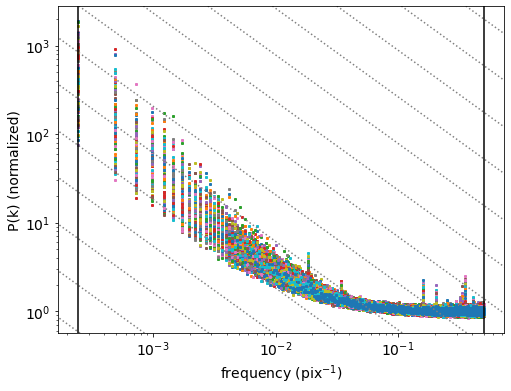

In [443]:
fig = plt.figure (figsize=(8,6))
ax = plt.subplot(111)

for jdx in range(idx):
    normalized = psflattened[jdx, abs(yfreqs)>0.2].mean()
    ax.scatter ( np.abs(yfreqs), psflattened[jdx]/normalized, s=2**2, zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x = np.logspace ( -4, 0., 30)
for aconst in np.logspace(-7,3,20):
    ax.plot ( x, 1./x *aconst, color='grey', ls=':' )
ax.axvline(1./4096., color='k')
ax.axvline(1./2., color='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel ( r'frequency (pix$^{-1}$)')
ax.set_ylabel ( r'P(k) (normalized)')
ax.set_rasterization_zorder ( 1 )

(0.0, 4096.0)

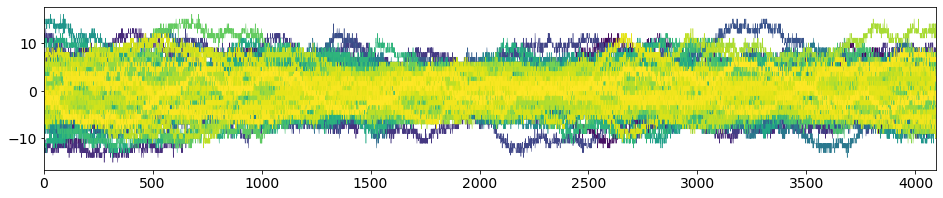

In [437]:
plt.figure(figsize=(16,3))
for jdx in range(idx):
    color = plt.cm.viridis(jdx / (idx-1))
    plt.plot(pcmed[jdx], lw=0.5, color=color)
plt.xlim(0,4096)

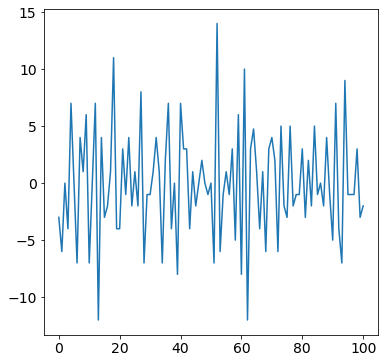

In [438]:
plt.plot ( pcmed[:idx, 0])

In [59]:
cds = rampA.cds ()

In [68]:
beta = (1.-0.68)/2.
np.quantile(cds, [beta,0.5,1.-beta])

array([ 6., 20., 38.])

<AxesSubplot:>

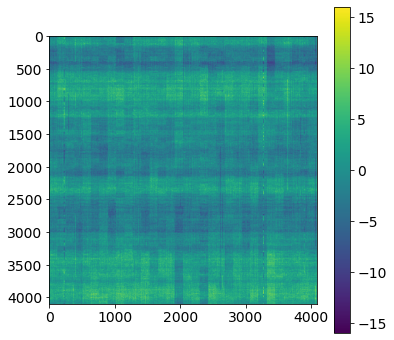

In [80]:
scaled_imshow ( fncd )